In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import scipy as sp
import numpy as np
import pandas as pd
import pickle


### Data downloaded from http://snap.stanford.edu/data/ego-Twitter.html
### They have 973 ego networks, I choose one of them

In [130]:
G_fb = nx.read_edgelist("../../../../Datasets/twitter/78813.edges", 
    create_using = nx.DiGraph(), nodetype = int)
data = pd.read_csv('../../../../Datasets/twitter/78813.feat', 
    sep=" ", header=None)

In [3]:
I = nx.incidence_matrix(G_fb,oriented=True).todense()
print(I.shape)

(231, 2861)


### each row of the Incidence matrix corrsponds to a node and each column to an edge
### -1 appears for the source  of an edge and 1 for the destination of the edge.
### Here we have 231 Nodes and 2861 edges

In [5]:
data.head()

,0,1,2,3,4,5,6,7,8,9,...,1116,1117,1118,1119,1120,1121,1122,1123,1124,1125
0,55384770,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,55252378,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,10461992,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,14154082,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,36412963,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Out of the 1126 columns, the first one is index of the node and the rest are the features

### To create edge feature, we concatenate features of the source node and the destination node
### For each edge now we have 1125*2 =2250 feature

In [10]:
cnt =0
l= []
for e in G_fb.edges():
    #print(e[0],e[1])
    s = pd.concat([data[data[0]==e[0]].iloc[0,1:],
              data[data[0]==e[1]].iloc[0,1:]])
    l.append(s)
df_features = pd.concat(l,axis=1).T
df_features.shape

(2861, 2250)

## In this dataset, we do not have any edge weight
### I generate edge weights using a 3 layered neural network.

In [38]:
import torch
from torch import nn
from torch.autograd import Variable
from torch import optim
import torch.nn.functional as F
def make_fc(num_layers=3, num_features=202, num_targets=1,
            intermediate_size=15, regularizers = True):
    net_layers = [nn.Linear(num_features, intermediate_size)]
    for hidden in range(num_layers-2):
        net_layers.append(nn.Linear(intermediate_size, intermediate_size))
        net_layers.append(nn.Tanh())
    net_layers.append(nn.Linear(intermediate_size, num_targets))
    net_layers.append(nn.ReLU())
    return nn.Sequential(*net_layers)
net = make_fc()

###   We have only 2861 edges,. I consider only 200 features to avoid overfitting. I also add 2 random numeric features.

In [44]:
x = np.c_[np.r_[np.random.normal(0, 1, (1430, 2)), np.random.normal(10, 1, (1431, 2))],
     df_features.values[:,100:300]]
X = torch.tensor(x,dtype=torch.float)
y = 2*net(X)

In [45]:
y.max(), y.min(), y.median(), y.mean()

(tensor(0.8673, grad_fn=<MaxBackward1>),
 tensor(0.0205, grad_fn=<MinBackward1>),
 tensor(0.5017, grad_fn=<MedianBackward0>),
 tensor(0.5015, grad_fn=<MeanBackward0>))

## y is the synthetically genrated weight of the edges

(array([  4.,  29.,  60., 151., 558., 898., 698., 374.,  82.,   7.]),
 array([0.02046466, 0.10515069, 0.18983673, 0.27452275, 0.3592088 ,
        0.44389483, 0.52858084, 0.6132669 , 0.6979529 , 0.78263897,
        0.867325  ], dtype=float32),
 <a list of 10 Patch objects>)

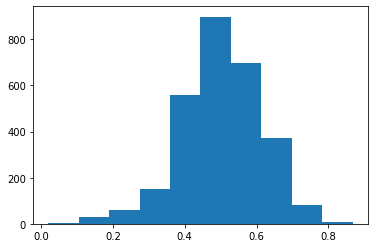

In [46]:
plt.hist(y.detach().numpy())

In [47]:
x.shape, y.shape

((2861, 202), torch.Size([2861, 1]))

In [48]:
## save 
# with open('Graph.npy', 'wb') as f:

#     np.save(f,I)
#     np.save(f, x)
#     np.save(f, y.squeeze().detach().numpy())


In [2]:
with open('Graph.npy', 'rb') as f:

    A = np.load(f)

    data = np.load(f)
    c = np.load(f)

## In this case, the instances have different start and end point. So, in the equality constraint of the form $Ax=b$, the $b$ vector is different from instances to instances

### In this network, not any wo nodes are connected to each other. So I write this function to validate if a path exit between two nodes

In [90]:
import gurobipy as gp
def valid_instances(source,destination) :  
    b = np.zeros(len(A))
    b [source] = -1
    b[destination ]= 1
    model = gp.Model()
    model.setParam('OutputFlag', 0)
    x = model.addMVar(shape=A.shape[1], vtype=gp.GRB.BINARY, name="x")
    model.setObjective(c @x, gp.GRB.MINIMIZE)
    model.addConstr(A @ x == b, name="eq")
    model.optimize()
    if model.status==2:
        if x.x.sum() >2:
            return True
    return False

### Now we add make a list of all the valid instances identified bya source and destination node

In [92]:
instances = []
for i in range(len(A)):
    for j in range(i-1):
        if valid_instances(i,j):
            instances.append((i,j))
            

In [5]:
print(len(instances))
### We have generated 12300 instances
# with open('instances.pickle', 'wb') as handle:
#      pickle.dump(instances, handle)

12300


In [4]:
with open('instances.pickle', 'rb') as handle:
    instances = pickle.load(handle)

#### Each Instance is a tuple: (source,destination)

In [124]:
#To load the data
with open('Graph.npy', 'rb') as f:

    A = np.load(f)

    data = np.load(f)
    c = np.load(f)
# the b vector is instance specific
# for one instance
source,dest = instances[0]
b = np.zeros(len(A))
b[source] =-1
b[dest ]=1